# Week 4

**`Market-Simulation::baseline-models`**
* **`AAFT`**: amplitude adjusted fourier transform baseline model
* **`VAR`**: vector autoregressive baseline model

In [1]:
# change current working directory
%cd ..

/Users/alpha/Developer/qtrader


In [2]:
# suppress warning messages
import warnings
warnings.filterwarnings('ignore')

# data provider
from qtrader.envs.data_loader import Finance
# pandas.DataFrame cleaner
from qtrader.utils.pandas import clean

# YAML parser
import yaml

# scientific programming
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR as _VAR
import statsmodels.tsa.vector_ar.util as var_util

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# fetch configuration file
config = yaml.load(open('config/log/week_4.yaml', 'r'))

# configuration summary
print(f"start date: {config['start_date']}")
print(f"trading frequency: {config['freq']}")
print(f"trading universe: {config['tickers']}")

start date: 2015-01-01
trading frequency: W-FRI
trading universe: ['AAPL', 'GE', 'JPM', 'MSFT', 'VOD', 'GS', 'TSLA', 'MMM']


### Data Source

Fetch prices, simple-relative returns and log-returns.

In [4]:
# prices
prices = clean(Finance.Prices(config['tickers'],
                              config['start_date'],
                              freq=config['freq'],
                              csv=config['csv_file_prices']))


# returns
returns = clean(Finance.Returns(config['tickers'],
                                config['start_date'],
                                freq=config['freq'],
                                csv=config['csv_file_returns']))

# log-returns
rhos = np.log(1 + returns)

## Market Simulation: Baseline Models

Computationally easy models used as a baseline for state-of-the-art generative models.

### Surrogates: Amplitude Adjusted Fourier Transform (AAFT)

Preserve first and second order statistical moments by:

1. Fourier Transformation of multivariate time-series
2. Randomisation of Phase
3. Inverse Fourier Transaformation

The identity of the autocorrelation functions is based on the fact that the original time series and the surrogate
have per construction the same power spectrum, which in turn is linked to the autocorrelation function via the
[Wiener–Khinchin theorem](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem).

In [5]:
def AAFT(df, random=np.random.uniform, random_state=None):
    """Amplitude Adjusted Fourier Transform Baseline Generator."""
    # set random seed
    np.random.seed(random_state)
    # Operate on numpy.ndarray
    ts = df.values
    # 2d time-series format
    _ts = ts.reshape(len(ts), -1)
    # Odd number of samples
    if len(_ts) % 2 != 0:
        _ts = _ts[1:, :]
    # Generated time-series
    ts_gen = np.empty_like(_ts)
    for i, tsi in enumerate(_ts.T):
        # Fourier Transaformation (real-valued signal)
        F_tsi = np.fft.rfft(tsi)
        # Randomization of Phase
        rv_phase = np.exp(random(0, np.pi, len(F_tsi)) * 1.0j)
        # Generation of new time-series
        F_tsi_new = F_tsi * rv_phase
        # Inverse Fourier Transformation
        ts_gen[:, i] = np.fft.irfft(F_tsi_new)
    # Create pandas DataFrame
    df_gen = pd.DataFrame(ts_gen, columns=df.columns,
                          index=df.index[-len(ts_gen):])
    return df_gen

In [6]:
# prices time-series generation
prices_gen = AAFT(prices, random=np.random.normal, random_state=13)

# returns time-series generation
returns_gen = AAFT(returns, random=np.random.normal, random_state=13)

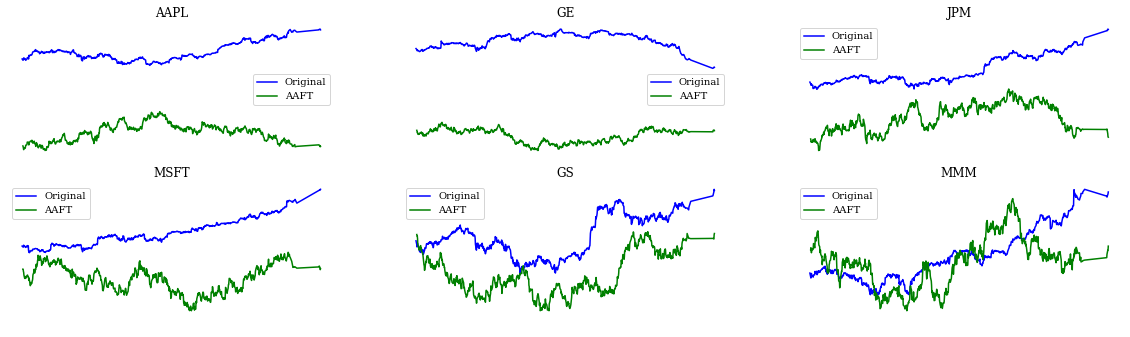

In [7]:
# time-series plots
fig, axes = plt.subplots(nrows=2, ncols=int(prices.shape[1] / 2), figsize=(20.0, 6.0))
for j, (ax, ticker) in enumerate(zip(axes.flatten(), prices.columns)):
    prices[ticker].plot(ax=ax, label="Original")
    prices_gen[ticker].plot(ax=ax, label="AAFT")
    ax.set(title=ticker, xticks=[], yticks=[])
    ax.axis('off')
    ax.legend();

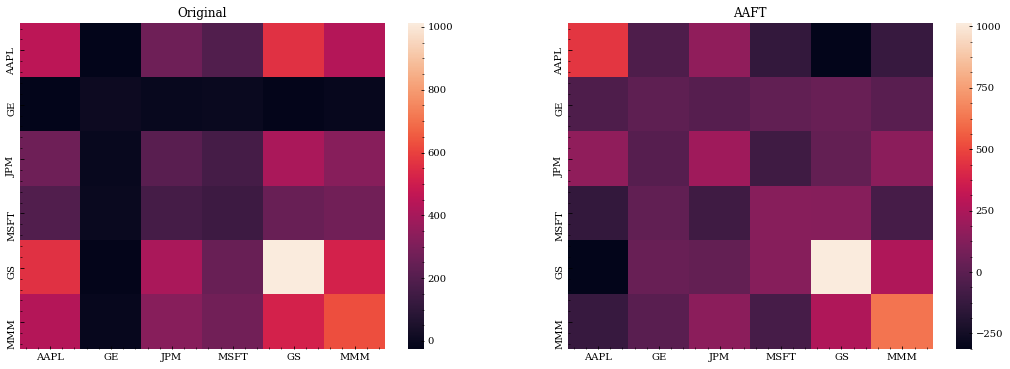

In [8]:
# statistical tests: covariances
fig, axes = plt.subplots(ncols=2, figsize=(18.0, 6.0))
sns.heatmap(prices.cov(), ax=axes[0])
axes[0].set_title("Original")
sns.heatmap(prices_gen.cov(), ax=axes[1])
axes[1].set_title("AAFT");

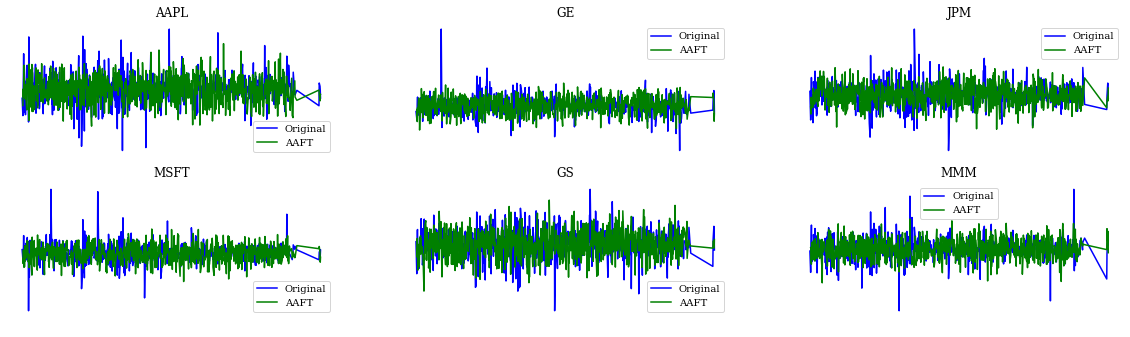

In [9]:
# time-series plots
fig, axes = plt.subplots(nrows=2, ncols=int(returns.shape[1] / 2), figsize=(20.0, 6.0))
for j, (ax, ticker) in enumerate(zip(axes.flatten(), returns.columns)):
    returns[ticker].plot(ax=ax, label="Original")
    returns_gen[ticker].plot(ax=ax, label="AAFT")
    ax.set(title=ticker, xticks=[], yticks=[])
    ax.axis('off')
    ax.legend();

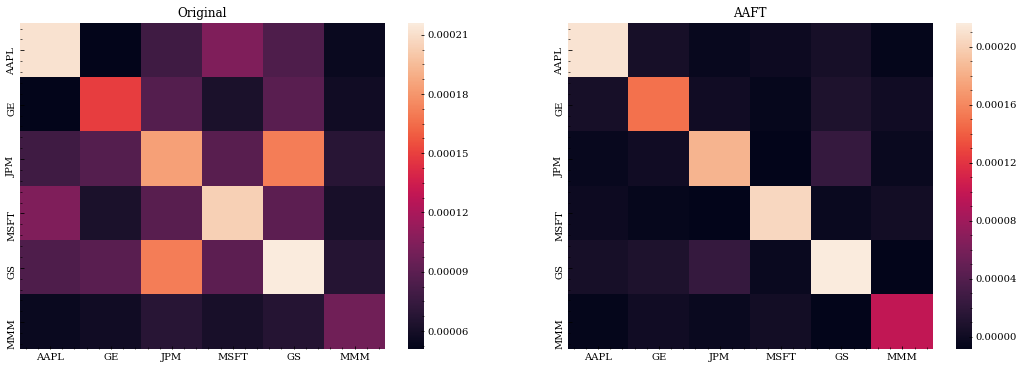

In [10]:
# statistical tests: covariances
fig, axes = plt.subplots(ncols=2, figsize=(18.0, 6.0))
sns.heatmap(returns.cov(), ax=axes[0])
axes[0].set_title("Original")
sns.heatmap(returns_gen.cov(), ax=axes[1])
axes[1].set_title("AAFT");

### Vector Autoregressive Process (VAR)

We are interested in modeling a $T \times K$ multivariate time series $Y$,
where $T$ denotes the number of observations and $K$ the number of variables.
One way of estimating relationships between the time series and their lagged values is
the **Vector Autoregression (VAR) Process**:

\begin{aligned}
    Y_{t}   &= A_{1} Y_{t-1} + A_{2} + Y_{t-2} + \ldots + A_{p} + Y_{t-p} + u_{t}\\
            &= \sum_{i=1}^{p} A_{i} Y_{t-i} + u_{t}\\
            & u_{t} \sim \text{Normal}(0, \Sigma_{u})
\end{aligned}

where $A_{i} \in R^{K \times K}$ a coefficient matrix.

In [11]:
def VAR(df, max_order=15):
    """Vector Autoregressive Baseline Generator."""
    # VAR model
    if isinstance(df, pd.DataFrame):
        var = _VAR(df.values)
    elif isinstance(df, np.ndarray):
        var = _VAR(df)
    # fit model
    model = var.fit(maxlags=max_order, ic='aic')
    # simulation
    ts_gen = var_util.varsim(model.coefs, model.intercept,
                             model.sigma_u, steps=len(df.values))
    # Create pandas DataFrame
    df_gen = pd.DataFrame(ts_gen, columns=df.columns,
                          index=df.index[-len(ts_gen):])
    return df_gen

In [12]:
# returns time-series generation
returns_gen = VAR(returns, 5)

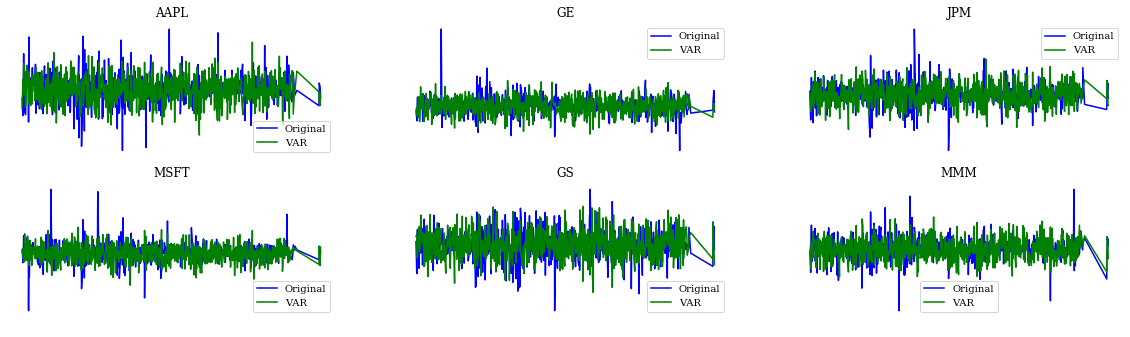

In [13]:
# time-series plots
fig, axes = plt.subplots(nrows=2, ncols=int(returns.shape[1] / 2), figsize=(20.0, 6.0))
for j, (ax, ticker) in enumerate(zip(axes.flatten(), returns.columns)):
    returns[ticker].plot(ax=ax, label="Original")
    returns_gen[ticker].plot(ax=ax, label="VAR")
    ax.set(title=ticker, xticks=[], yticks=[])
    ax.axis('off')
    ax.legend();

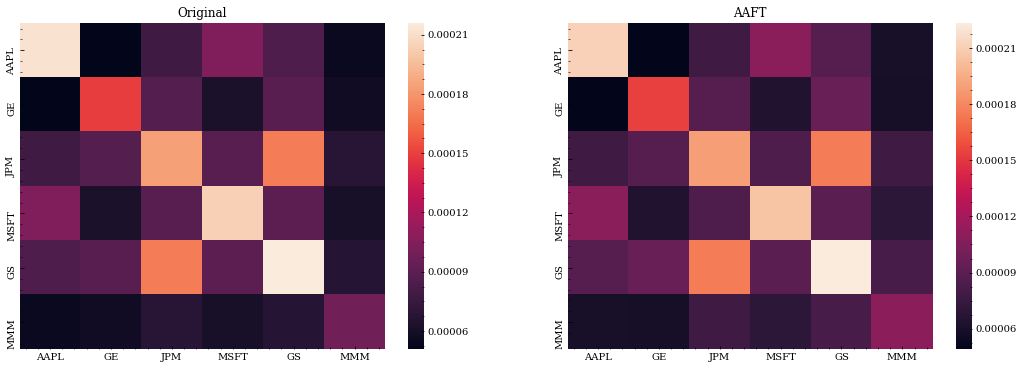

In [14]:
# statistical tests: covariances
fig, axes = plt.subplots(ncols=2, figsize=(18.0, 6.0))
sns.heatmap(returns.cov(), ax=axes[0])
axes[0].set_title("Original")
sns.heatmap(returns_gen.cov(), ax=axes[1])
axes[1].set_title("AAFT");